## Imports

In [ ]:
# !pip install KeyBERT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from keybert import KeyBERT

## Pre-processing

In [ ]:
# Download required NLTK data
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
EXCEL_FILE = "nlp_stackoverflow_dataset.xlsx"
df_raw = pd.read_excel(EXCEL_FILE, sheet_name="Raw_Data")

# Removing duplicates based on 'title' and 'description'
df_no_duplicates = df_raw.drop_duplicates(subset=['title', 'description'], keep='first')
print(f"Removed duplicates. Original rows: {len(df_raw)}, After duplicate removal: {len(df_no_duplicates)}")

# Removing rows where 'accepted_answer' is "no accepted answer"
df_no_empty_answers = df_no_duplicates[df_no_duplicates['accepted_answer'] != 'No accepted answer']
print(f"Removed rows with 'no accepted answer'. Remaining rows: {len(df_no_empty_answers)}")

#Converting to lowercase
df_lowercase = df_no_empty_answers.copy()
for column in ['title', 'description', 'tags', 'accepted_answer', 'more_accepted_answers']:
    df_lowercase[column] = df_lowercase[column].astype(str).str.lower()
print("Step 3: Converted text to lowercase")

#Removing HTML tags
df_no_html = df_lowercase.copy()
def remove_html_tags(text):
    if isinstance(text, str):
        return re.sub(r'<[^>]+>', '', text)
    return text

for column in ['title', 'description', 'accepted_answer', 'more_accepted_answers']:
    df_no_html[column] = df_no_html[column].apply(remove_html_tags)
print("Step 4: Removed HTML tags (<p> and others)")

#Removing punctuation, special symbols, and '39' (from raw data)
df_no_punctuation = df_no_html.copy()
def remove_punctuation(text):
    if isinstance(text, str):
        #remove '39' (representing single quote in raw data)
        text = re.sub(r'\b39\b', '', text)
        # remove punctuation and special symbols
        return re.sub(r'[^\w\s]', '', text)
    return text

for column in ['title', 'description', 'tags', 'accepted_answer', 'more_accepted_answers']:
    df_no_punctuation[column] = df_no_punctuation[column].apply(remove_punctuation)
print("Step 5: Removed punctuation, special symbols, and '39' from raw data")

# Tokenization
df_tokenized = df_no_punctuation.copy()
def tokenize_text(text):
    if isinstance(text, str):
        return ' '.join(word_tokenize(text))
    return text

for column in ['title', 'description', 'accepted_answer', 'more_accepted_answers']:
    df_tokenized[column] = df_tokenized[column].apply(tokenize_text)
print("Step 6: Tokenized text")

#Remove stop words
df_no_stopwords = df_tokenized.copy()
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    if isinstance(text, str):
        tokens = word_tokenize(text)
        return ' '.join([word for word in tokens if word not in stop_words])
    return text

for column in ['title', 'description', 'accepted_answer', 'more_accepted_answers']:
    df_no_stopwords[column] = df_no_stopwords[column].apply(remove_stopwords)
print("Step 7: Removed stop words")

#Lemmatization
df_preprocessed = df_no_stopwords.copy()
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    if isinstance(text, str):
        tokens = word_tokenize(text)
        return ' '.join([lemmatizer.lemmatize(word) for word in tokens])
    return text

for column in ['title', 'description', 'accepted_answer', 'more_accepted_answers']:
    df_preprocessed[column] = df_preprocessed[column].apply(lemmatize_text)
print("Step 8: Applied lemmatization")

# Create output Excel file with separate sheets for each step
OUTPUT_FILE = "nlp_stackoverflow_processed.xlsx"
with pd.ExcelWriter(OUTPUT_FILE, engine='openpyxl') as writer:
    df_raw.to_excel(writer, sheet_name='Raw_Data', index=False)
    df_no_duplicates.to_excel(writer, sheet_name='No_Duplicates', index=False)
    df_no_empty_answers.to_excel(writer, sheet_name='No_Empty_Answers', index=False)
    df_lowercase.to_excel(writer, sheet_name='Lowercase', index=False)
    df_no_html.to_excel(writer, sheet_name='No_HTML', index=False)
    df_no_punctuation.to_excel(writer, sheet_name='No_Punctuation', index=False)
    df_tokenized.to_excel(writer, sheet_name='Tokenized', index=False)
    df_no_stopwords.to_excel(writer, sheet_name='No_Stopwords', index=False)
    df_preprocessed.to_excel(writer, sheet_name='Preprocessed_Data', index=False)

print(f"Saved all preprocessing steps to '{OUTPUT_FILE}'")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Removed duplicates. Original rows: 21246, After duplicate removal: 20534
Removed rows with 'no accepted answer'. Remaining rows: 7654
Step 3: Converted text to lowercase
Step 4: Removed HTML tags (<p> and others)
Step 5: Removed punctuation, special symbols, and '39' from raw data
Step 6: Tokenized text
Step 7: Removed stop words
Step 8: Applied lemmatization
Saved all preprocessing steps to 'nlp_stackoverflow_processed.xlsx'


## Graphical visualisations

In [ ]:
# Visualization directory
if not os.path.exists('visualizations'):
    os.makedirs('visualizations')


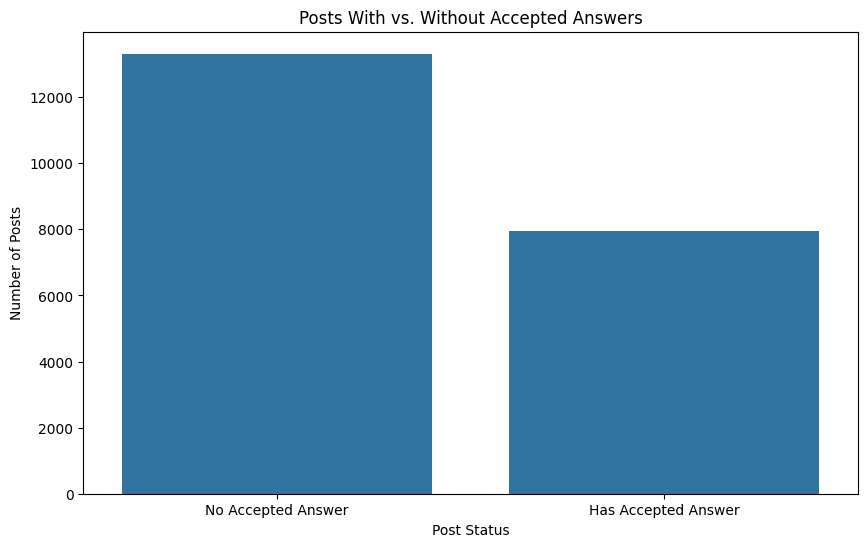

In [ ]:

# ==================== Posts with vs. without Accepted Answers ====================
# Count posts with and without accepted answers
has_accepted = df_raw['accepted_answer'] != 'No accepted answer'
acceptance_counts = has_accepted.value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=acceptance_counts.index.map({True: 'Has Accepted Answer', False: 'No Accepted Answer'}),
            y=acceptance_counts.values)
plt.title('Posts With vs. Without Accepted Answers')
plt.xlabel('Post Status')
plt.ylabel('Number of Posts')
plt.show()
plt.savefig('visualizations/7_accepted_answers_status.png')
plt.close()



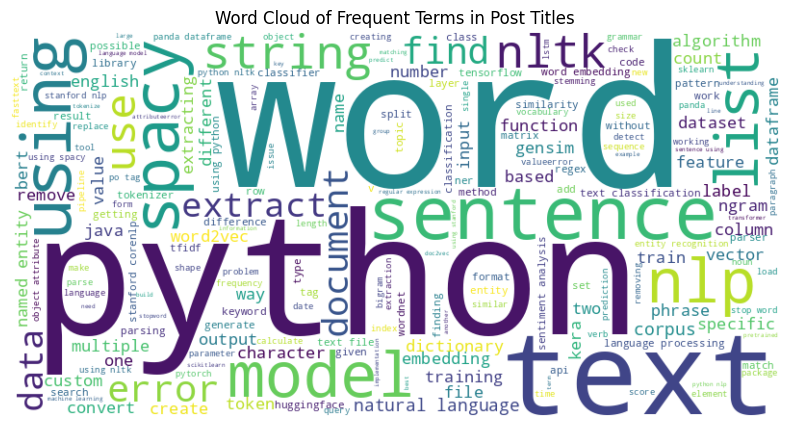

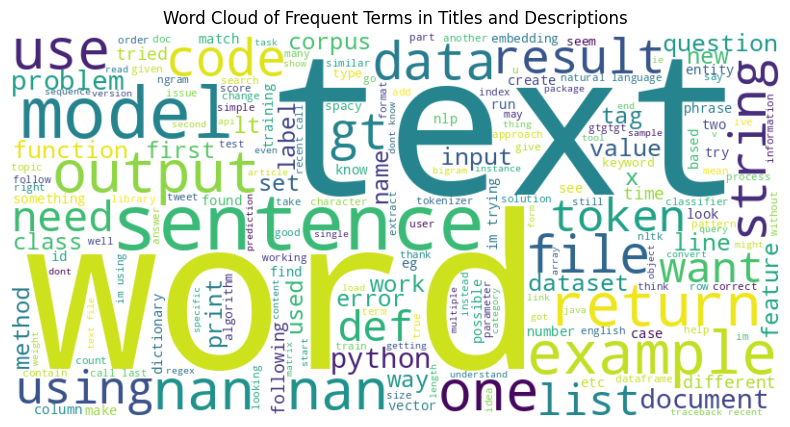

In [ ]:
# ==================== Word Cloud ====================
# Title word cloud
title_text = ' '.join(df_preprocessed['title'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(title_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Frequent Terms in Post Titles')
plt.show()
plt.savefig('visualizations/1_wordcloud_titles.png')
plt.close()



# Combined word cloud (titles + descriptions)
combined_text = ' '.join(df_preprocessed['title'].dropna()) + ' ' + ' '.join(df_preprocessed['description'].dropna())
wordcloud_combined = WordCloud(width=800, height=400, background_color='white',
                               max_words=200, collocations=True).generate(combined_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_combined, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Frequent Terms in Titles and Descriptions')
plt.show()
plt.savefig('visualizations/2_wordcloud_combined.png')
plt.close()

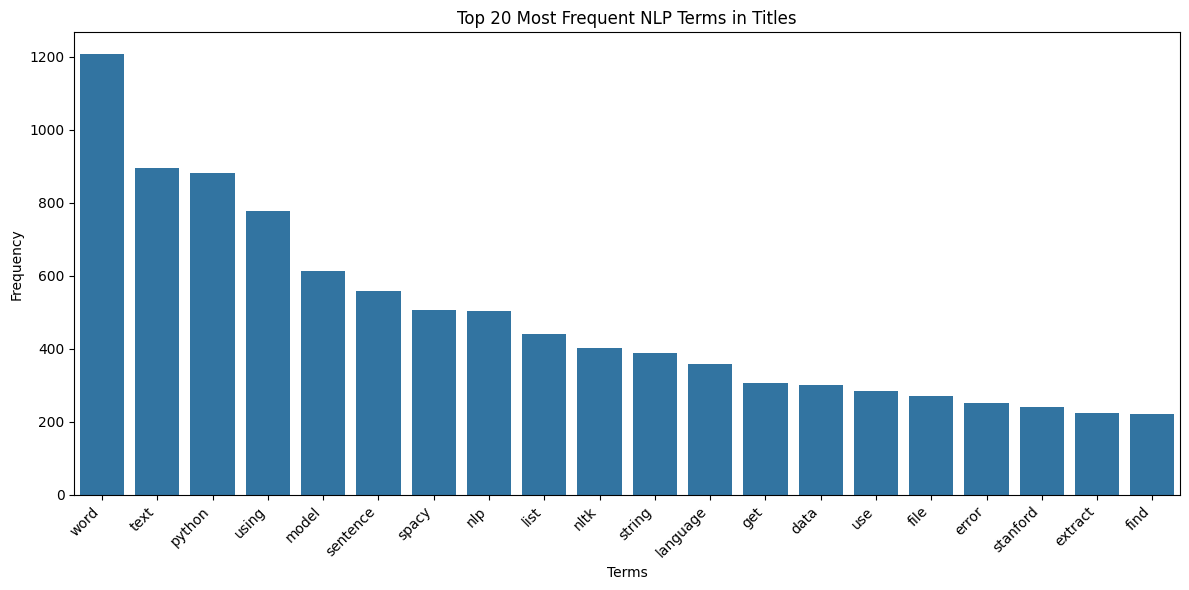

In [ ]:
# ==================== Top NLP Terms Bar Chart ====================
# Get all text from titles for frequency analysis
all_title_words = ' '.join(df_preprocessed['title'].dropna()).split()
# Count word frequencies
word_freq = Counter(all_title_words)
# Get top 20 most common words
top_words = word_freq.most_common(20)

# Create bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in top_words], y=[word[1] for word in top_words])
plt.title('Top 20 Most Frequent NLP Terms in Titles')
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.savefig('visualizations/3_top_terms_barchart.png')

plt.close()


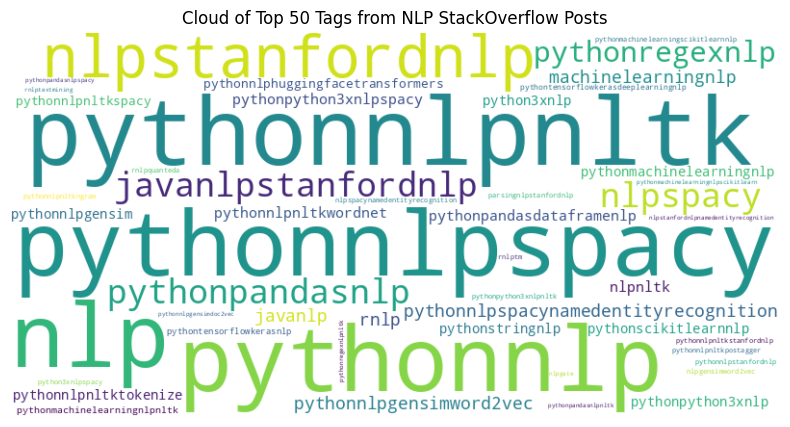

In [ ]:

# ====================Tag Cloud ====================
# Extract and count tags
all_tags = []
for tags_str in df_preprocessed['tags'].dropna():
    # Assume tags are separated by spaces or commas
    tags = re.split(r'[,\s]+', str(tags_str))
    all_tags.extend([tag.strip() for tag in tags if tag.strip()])

tag_freq = Counter(all_tags)
top_tags = tag_freq.most_common(50)

# Create tag cloud
tag_text = ' '.join([tag[0] + ' ' * int(tag[1]) for tag in top_tags])
tag_cloud = WordCloud(width=800, height=400, background_color='white',
                      max_words=50).generate(tag_text)

plt.figure(figsize=(10, 5))
plt.imshow(tag_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Cloud of Top 50 Tags from NLP StackOverflow Posts')
plt.show()
plt.savefig('visualizations/4_tag_cloud.png')
plt.close()


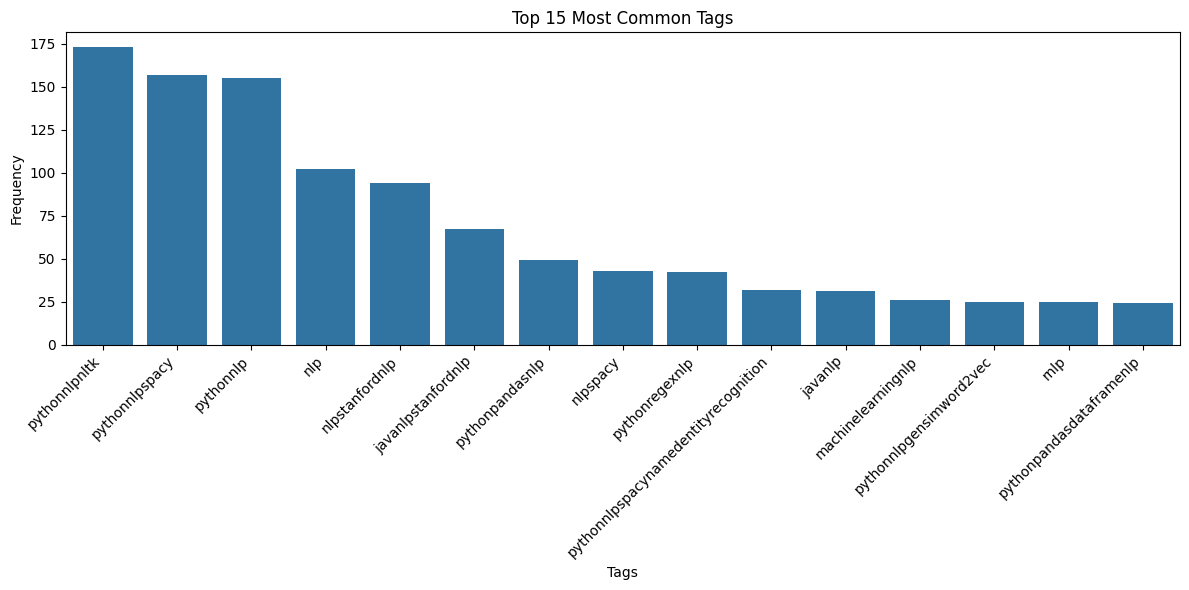

In [ ]:

# ==================== Tag Frequency Bar Chart ====================
# Create bar chart for top 15 tags
top_15_tags = tag_freq.most_common(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=[tag[0] for tag in top_15_tags], y=[tag[1] for tag in top_15_tags])
plt.title('Top 15 Most Common Tags')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.savefig('visualizations/5_tag_frequency.png')
plt.close()



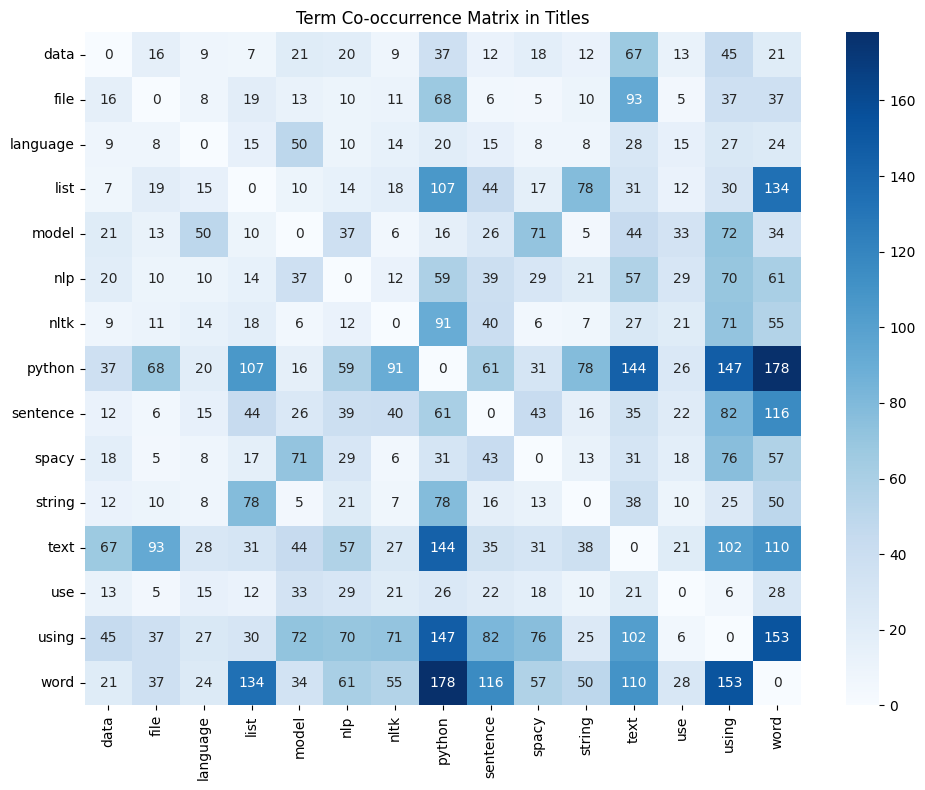

In [ ]:
# ==================== Term Co-occurrence Heatmap ====================
# Use CountVectorizer to get term frequencies
vectorizer = CountVectorizer(max_features=15, stop_words='english')
X = vectorizer.fit_transform(df_preprocessed['title'].dropna())
terms = vectorizer.get_feature_names_out()

# Calculate co-occurrence matrix
co_matrix = (X.T @ X).toarray()
np.fill_diagonal(co_matrix, 0)  # Remove self-connections

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=terms, yticklabels=terms)
plt.title('Term Co-occurrence Matrix in Titles')
plt.tight_layout()
plt.show()
plt.savefig('visualizations/6_term_cooccurrence.png')
plt.close()



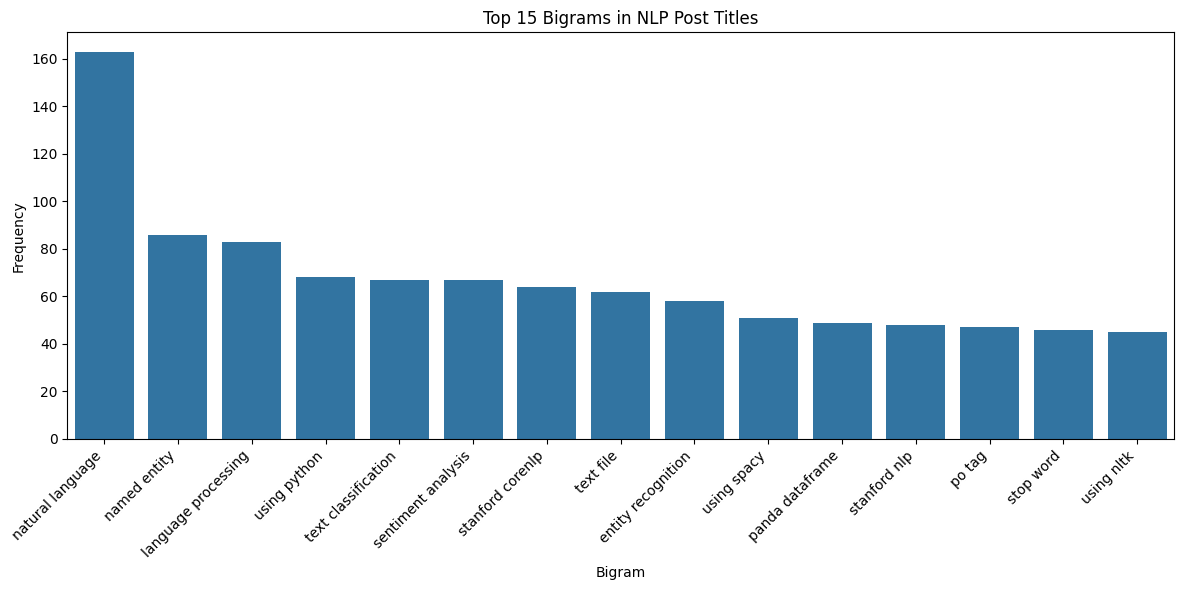

In [ ]:
# ==================== Top Bigrams Visualization ====================
# Extract bigrams from titles
def get_bigrams(text):
    tokens = word_tokenize(text)
    return list(nltk.bigrams(tokens))

# Apply to preprocessed titles
all_bigrams = []
for title in df_preprocessed['title'].dropna():
    all_bigrams.extend(get_bigrams(title))

# Count bigram frequencies
bigram_freq = Counter(all_bigrams)
top_bigrams = bigram_freq.most_common(15)

# Create bar chart for top bigrams
plt.figure(figsize=(12, 6))
sns.barplot(x=[' '.join(bg[0]) for bg in top_bigrams],
            y=[bg[1] for bg in top_bigrams])
plt.title('Top 15 Bigrams in NLP Post Titles')
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.savefig('visualizations/8_top_bigrams.png')
plt.close()


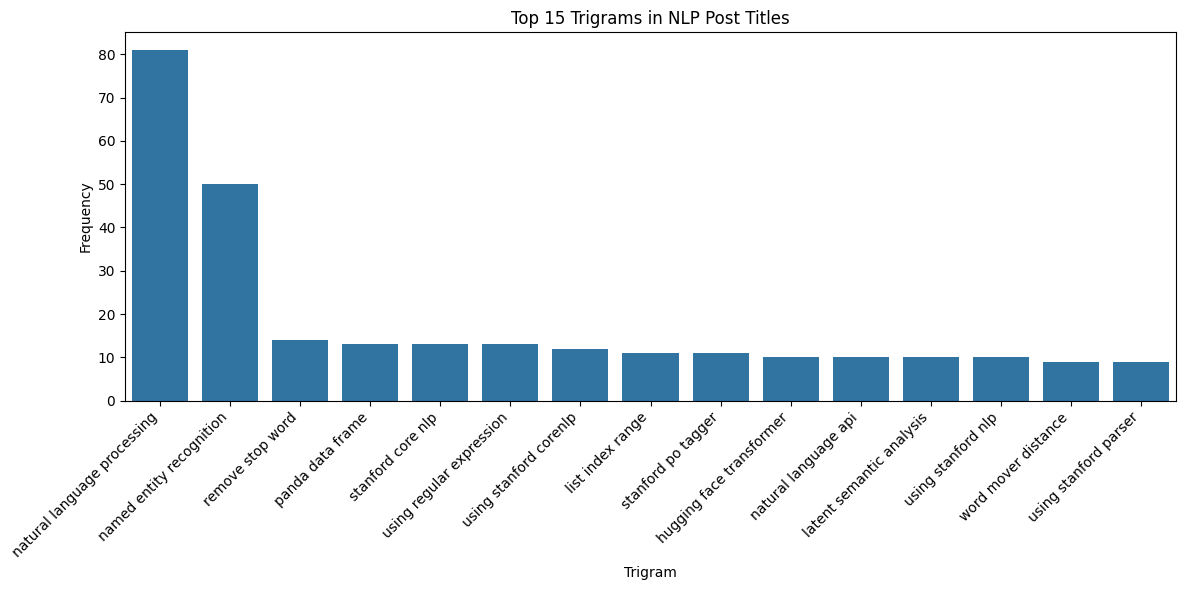

In [ ]:
# ==================== Top Bigrams Visualization ====================
# Extract bigrams from titles
def get_trigrams(text):
    tokens = word_tokenize(text)
    return list(nltk.trigrams(tokens))

# Apply to preprocessed titles
all_trigrams = []
for title in df_preprocessed['title'].dropna():
    all_trigrams.extend(get_trigrams(title))

# Count bigram frequencies
trigram_freq = Counter(all_trigrams)
top_trigrams = trigram_freq.most_common(15)

# Create bar chart for top bigrams
plt.figure(figsize=(12, 6))
sns.barplot(x=[' '.join(bg[0]) for bg in top_trigrams],
            y=[bg[1] for bg in top_trigrams])
plt.title('Top 15 Trigrams in NLP Post Titles')
plt.xlabel('Trigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.savefig('visualizations/8_top_trigrams.png')
plt.close()


# Categorisation

In [ ]:
# Loading preprocessed dataset
df = pd.read_excel("nlp_stackoverflow_processed.xlsx", sheet_name="Preprocessed_Data")

# Combine title and description into a single text column
df['text'] = df['title'].astype(str) + " " + df['description'].astype(str)

# Additional preprocessing
def clean_text(text):
    if pd.isna(text) or text.strip() == "":
        return ""
    text = re.sub(r'http[s]?[^\s]+', '', text)
    text = re.sub(r'quot[^ ]+pyquot', '', text)
    text = re.sub(r'[^ ]+[/\\][^ ]+', '', text)
    text = re.sub(r'\b\w*\d+\w*\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['text'].apply(clean_text)

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['text'])

# Apply K-Means clustering with 8 clusters
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
df['category'] = kmeans.fit_predict(tfidf_matrix)

# Initialize KeyBERT model
kw_model = KeyBERT()

# Function to extract keywords
def extract_keywords(text, top_n=10):
    if pd.isna(text) or text.strip() == "":
        return []
    keywords = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 2),
        stop_words='english',
        top_n=top_n
    )
    filtered_keywords = [
        kw[0] for kw in keywords
        if not re.search(r'\d', kw[0]) and '/' not in kw[0] and 'quot' not in kw[0]
    ]
    return filtered_keywords[:top_n]

# Extract keywords for each category
category_keywords = {}
for category in df['category'].unique():
    category_texts = df[df['category'] == category]['text'].head(100).str.cat(sep=' ')
    keywords = extract_keywords(category_texts, top_n=10)
    category_keywords[category] = keywords
    print(f"Category: Cluster {category}")
    print(f"Keywords: {keywords}\n")

# Updated category rules with new categories
category_rules = {
    "Coding Errors": {'error': 4, 'exception': 4, 'traceback': 4, 'fail': 3, 'bug': 3, 'indexing': 3, 'cmake': 3, 'make': 3},
    "Library-Specific Issues": {'nltk': 5, 'spacy': 5, 'huggingface': 5, 'transformers': 5, 'tensorflow': 5, 'bert': 5, 'opennlp': 5, 'glove': 5, 'bertopic': 5, 'openaiembeddings': 5},
    "Model Performance Issues": {'model': 3, 'accuracy': 3, 'performance': 3, 'training': 3, 'loss': 3, 'lstm': 3, 'underfitting': 3, 'retrain': 3, 'sequential': 2, 'optimizer': 3},
    "Tokenization/Chunking Issues": {'tokenize': 4, 'tokenizer': 4, 'chunking': 4, 'chunker': 4, 'pretrained': 3},
    "Vocabulary/Word List Issues": {'word': 4, 'list': 4, 'wordlist': 4, 'sentencewords': 3, 'embedding': 4, 'wordvectors': 4, 'vector': 3},
    "Keyword Extraction Issues": {'keyword': 4, 'extraction': 4, 'extracting': 4, 'topics': 3, 'term_frequency': 3},
    "Multiprocessing/Optimization Issues": {'multiprocessing': 5, 'shared_memory': 4, 'efficient': 3, 'nlppipe': 3},
    "Sentiment Analysis Issues": {'sentiment': 4, 'classification': 4, 'classifier': 4, 'analysis': 3},
    "Infrastructure/Storage Issues": {'aws': 4, 'store': 4, 'file': 3, 'image': 3, 'batch': 3},
    "Training-Related Errors": {'error': 4, 'training': 3, 'train_data': 3, 'train_loop': 3, 'dataset_train': 3}
}

# Refined category assignment function
def assign_category(keywords):
    keywords_lower = [kw.lower() for kw in keywords]
    category_scores = {cat: 0 for cat in category_rules}
    match_details = {cat: [] for cat in category_rules}

    for cat, rule_dict in category_rules.items():
        for kw in keywords_lower:
            for rk, weight in rule_dict.items():
                if rk in kw or kw in rk:
                    category_scores[cat] += weight
                    match_details[cat].append(f"{rk} (w={weight}) in {kw}")

    best_category = max(category_scores, key=category_scores.get)
    best_score = category_scores[best_category]

    print(f"Keywords: {keywords}")
    print(f"Scores: {category_scores}")
    print(f"Match Details: {match_details}")

    return best_category if best_score > 0 else "Miscellaneous Issues"

# Assign category names
keyword_to_category = {}
for cluster, keywords in category_keywords.items():
    category_name = assign_category(keywords)
    keyword_to_category[cluster] = category_name
    print(f"Cluster {cluster} assigned to: {category_name}\n")

# Map cluster numbers to category names
df['category_name'] = df['category'].map(keyword_to_category)

# Check distribution
print("\nCategory Distribution:")
print(df['category_name'].value_counts())

# Save results
with pd.ExcelWriter("nlp_stackoverflow_categorized.xlsx", engine='openpyxl') as writer:
    df.to_excel(writer, sheet_name='Categorized_Data', index=False)

with open("category_keywords.txt", "w") as f:
    for category, keywords in category_keywords.items():
        cat_name = keyword_to_category[category]
        f.write(f"Category: {cat_name}\n")
        f.write(f"Keywords: {', '.join(keywords)}\n\n")

print("Saved categorized dataset to 'nlp_stackoverflow_categorized.xlsx'")
print("Saved categories and keywords to 'category_keywords.txt'")

Category: Cluster 1
Keywords: ['store image', 'bert_modelget_topic_freq file', 'keywords aws', 'bert_modelget_topic_freq', 'bert_tokenizer', 'bert_model bertopic', 'bert_model bertopicverbosetrue', 'aws service', 'use bertopic', 'bert_model']

Category: Cluster 7
Keywords: ['chunk nltkne_chunknltkpos_tagnltkword_tokenizesent', 'nltkne_chunknltkpos_tagnltkword_tokenizesent', 'sentence chunker', 'improving chunker', 'opennlp chunking', 'nltkne_chunknltkpos_tagnltkword_tokenizesent binarytrue', 'chunking using', 'nltkne_chunk using', 'using nltkne_chunk', 'parameter chunker']

Category: Cluster 2
Keywords: ['train lstm', 'glove lstm', 'optimizer nlpbegin_training', 'nlpbegin_training', 'underfitting pretrained', 'modeltrain text', 'training_sequencethe_model', 'sequence training', 'retrain nlp', 'training word']

Category: Cluster 0
Keywords: ['marianbuild cmake', 'error srccmakefilesmariandircommonutilscppo', 'srccmakefilesmariandircommonutilscppo error', 'marian_version built', 'error s

In [ ]:
# Read the categorized data from nlp_stackoverflow_categorized.xlsx
categorized_df = pd.read_excel("/content/nlp_stackoverflow_categorized (5).xlsx", sheet_name="Categorized_Data")

# Append the categorized data as a new sheet in nlp_stackoverflow_processed.xlsx
with pd.ExcelWriter("/content/nlp_stackoverflow_processed_fin.xlsx", engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    categorized_df.to_excel(writer, sheet_name='Categorized_Data', index=False)

print("Appended categorized data as 'Categorized_Data' sheet in 'nlp_stackoverflow_processed_fin.xlsx'")

Appended categorized data as 'Categorized_Data' sheet in 'nlp_stackoverflow_processed_fin.xlsx'
